In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler

fnexpr='GSE117931/GSE117931_GPL14951.tsv'
fnmet='GSE117931/GSE117931_GPL13534.tsv'
fnassig='GSE117931/assig.csv'
nsamp=37
fnmodel='G-WGANGPREALstd90'
fnmodeld='D-WGANGPREALstd90'
filename = "wgangprealstd90"

#Función para contar número de parámetros del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# Definir el generador y el discriminador
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            #nn.Linear(512, 1024),
            #nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        return self.net(x)
        
# Leer datos
expression_data = pd.read_csv(fnexpr,sep='\t', index_col=0)
expression_data=expression_data.T
methylation_data = pd.read_csv(fnmet,sep='\t', index_col=0)
methylation_data=methylation_data.T
assign_data = pd.read_csv(fnassig,sep='\t')

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 1:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). 
methylation_data.dropna(axis=1, inplace=True)
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)

#Normalizamos
scaler = MinMaxScaler()

# Asumiendo que expression_data, methylation_data y assign_data son tus DataFrames
expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir a DataFrame
expression_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
methylation_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

std_devs = expression_data.std()

# Calcular el percentil 75 de las desviaciones estándar
percentile_75 = std_devs.quantile(0.9)

# Filtrar las columnas que están por debajo del percentil 75 de variabilidad
cols_to_drop = std_devs[std_devs < percentile_75].index

# Eliminar estas columnas del DataFrame
expression_data = expression_data.drop(cols_to_drop, axis=1)

std_devs = methylation_data.std()

# Calcular el percentil 75 de las desviaciones estándar
percentile_75 = std_devs.quantile(0.9)

# Filtrar las columnas que están por debajo del percentil 75 de variabilidad
cols_to_drop = std_devs[std_devs < percentile_75].index

# Eliminar estas columnas del DataFrame
methylation_data = methylation_data.drop(cols_to_drop, axis=1)
#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"




In [2]:
# Convertir a Tensor y pasar a GPU
expression_data = torch.FloatTensor(expression_data.values).to(device)
methylation_data = torch.FloatTensor(methylation_data.values).to(device)
assign_data = torch.FloatTensor(assign_data.values).to(device)
combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)
# Modelos y optimizadores
gen = Generator(100,expression_data.shape[1] + methylation_data.shape[1]+assign_data.shape[1]).to(device)
disc = Discriminator(expression_data.shape[1] + methylation_data.shape[1]+assign_data.shape[1]).to(device)
start_epoch=0
#gen.load_state_dict(torch.load(f"{fnmodel}{start_epoch-1}.pth"))
#disc.load_state_dict(torch.load(f"{fnmodeld}{start_epoch-1}.pth"))
print(f'El modelo Generator tiene {count_parameters(gen)} parámetros entrenables.')
print(f'El modelo Discriminator tiene {count_parameters(disc)} parámetros entrenables.')
gen_optimizer = optim.RMSprop(gen.parameters(), lr=0.0002)
disc_optimizer = optim.RMSprop(disc.parameters(), lr=0.0002)


# Hiperparámetros adicionales
n_critic = 5 # Número de veces que se actualiza el discriminador por cada actualización del generador
lambda_gp = 10 # Coeficiente de penalización de gradiente

# Función de penalización de gradiente
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calcula la penalización del gradiente para WGAN-GP."""
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1).to(device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Entrenamiento
n_samples = combined_data.size(0)
batch_size = 8

n_epochs = 10000
start_time = time.time()
for epoch in range(start_epoch,n_epochs):
    for idx in range(0, n_samples, batch_size):
        # Entrenamiento del discriminador
        for nc in range(n_critic):
            real_data = combined_data[idx:idx+batch_size].to(device)
            current_batch_size = real_data.size(0)
           
            disc_optimizer.zero_grad()

            noise = torch.randn(current_batch_size, 100).to(device)
            fake_data = gen(noise).to(device)
            if ((epoch+1) % 100 == 0) and (idx ==0) and (nc==0):
                print(fake_data)
            real_preds = disc(real_data).to(device)
            fake_preds = disc(fake_data).to(device)
            
            # WGAN loss
            d_real_loss = -torch.mean(real_preds)
            d_fake_loss = torch.mean(fake_preds)
            
            gradient_penalty = compute_gradient_penalty(disc, real_data.data, fake_data.data)
            d_loss = d_real_loss + d_fake_loss + lambda_gp * gradient_penalty
            
            d_loss.backward()
            disc_optimizer.step()

        # Entrenamiento del generador
        gen_optimizer.zero_grad()
        
        noise = torch.randn(current_batch_size, 100).to(device)
        fake_data = gen(noise).to(device)
        fake_preds = disc(fake_data).to(device)

        # WGAN loss
        g_loss = -torch.mean(fake_preds)
        
        g_loss.backward()
        gen_optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Disc Loss: {d_loss.item()} | Gen Loss: {g_loss.item()}")
        end_time = time.time()

        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()
        torch.save(gen.state_dict(), f"{fnmodel}{epoch}.pth")
        torch.save(disc.state_dict(), f"{fnmodeld}{epoch}.pth")





El modelo Generator tiene 90602631 parámetros entrenables.
El modelo Discriminator tiene 44835841 parámetros entrenables.
tensor([[0.4961, 0.6122, 0.5896,  ..., 0.5358, 0.5987, 0.5021],
        [0.5042, 0.6280, 0.5950,  ..., 0.5468, 0.6542, 0.4670],
        [0.4893, 0.6704, 0.6110,  ..., 0.5640, 0.6861, 0.4551],
        ...,
        [0.5229, 0.6220, 0.5942,  ..., 0.5442, 0.6328, 0.4818],
        [0.5113, 0.6858, 0.6431,  ..., 0.5968, 0.7594, 0.4047],
        [0.5223, 0.6263, 0.5750,  ..., 0.5329, 0.5471, 0.5428]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch 100/10000 | Disc Loss: -114.10738372802734 | Gen Loss: 22.7089786529541
El código tardó 117.75852 segundos en ejecutarse.
tensor([[0.6289, 0.5869, 0.5383,  ..., 0.2985, 0.6796, 0.8673],
        [0.4084, 0.6988, 0.6976,  ..., 0.7597, 0.5692, 0.2838],
        [0.5037, 0.5948, 0.5869,  ..., 0.5933, 0.6438, 0.5208],
        ...,
        [0.4888, 0.6968, 0.6427,  ..., 0.7321, 0.5931, 0.3368],
        [0.7310, 0.8933, 0.8536

/home/fede/PyEnv/PB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-31 09:46:39.291802: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 09:46:39.349439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 09:46:39.349503: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 09:46:39.349550: E

Wasserstein Distance: 0.0439829629991004
KS Statistic: 0.10011877808920139, P-Value: 0.0
Distancia Euclidiana Promedio: 79.64843610701085
Accuracy: 0.34782608695652173

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.44      0.35         9
           1       0.44      0.29      0.35        14

    accuracy                           0.35        23
   macro avg       0.37      0.37      0.35        23
weighted avg       0.38      0.35      0.35        23



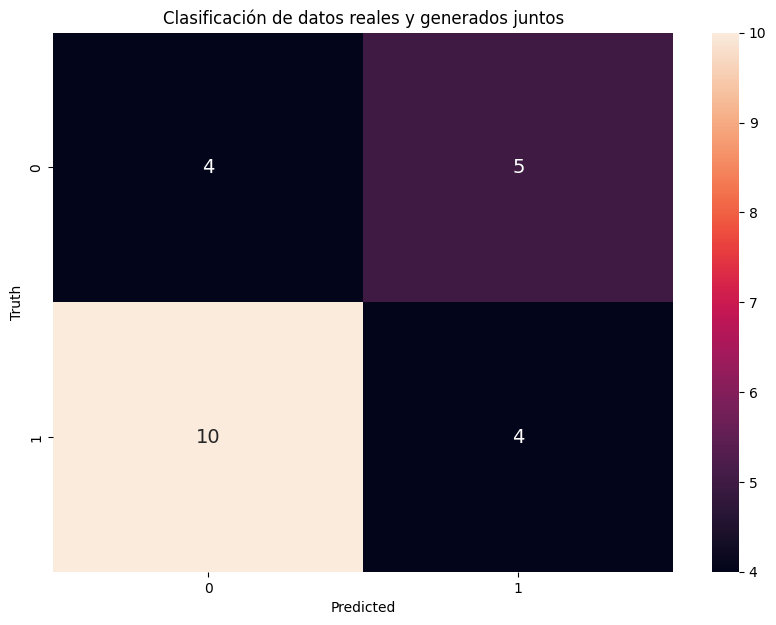

/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12



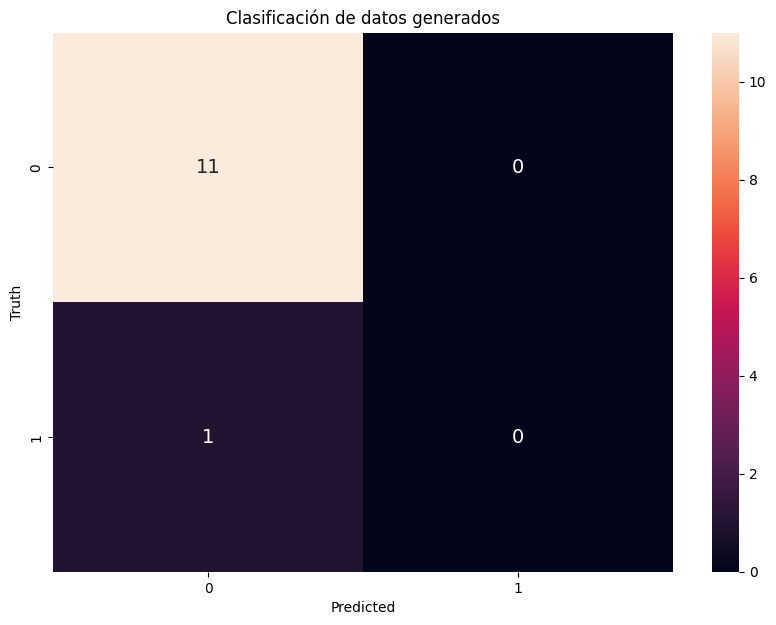

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.80      0.89         5

    accuracy                           0.92        12
   macro avg       0.94      0.90      0.91        12
weighted avg       0.93      0.92      0.91        12



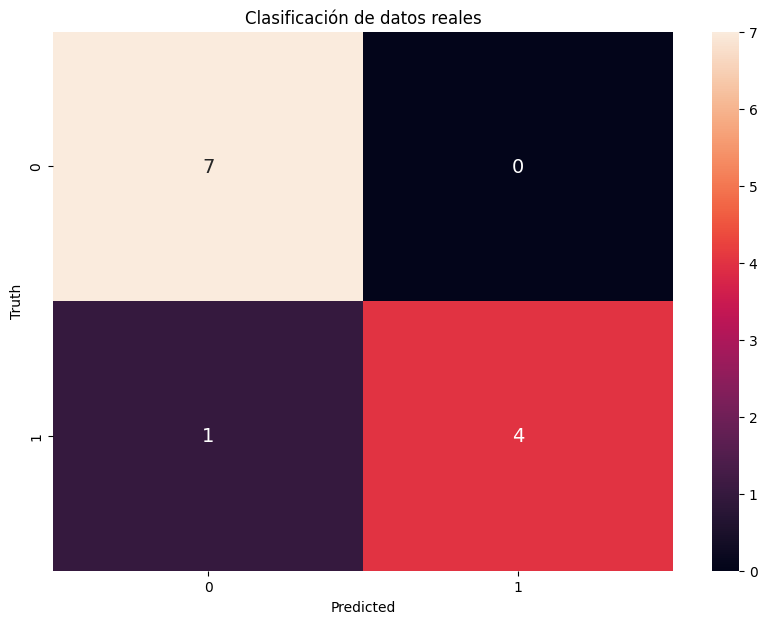

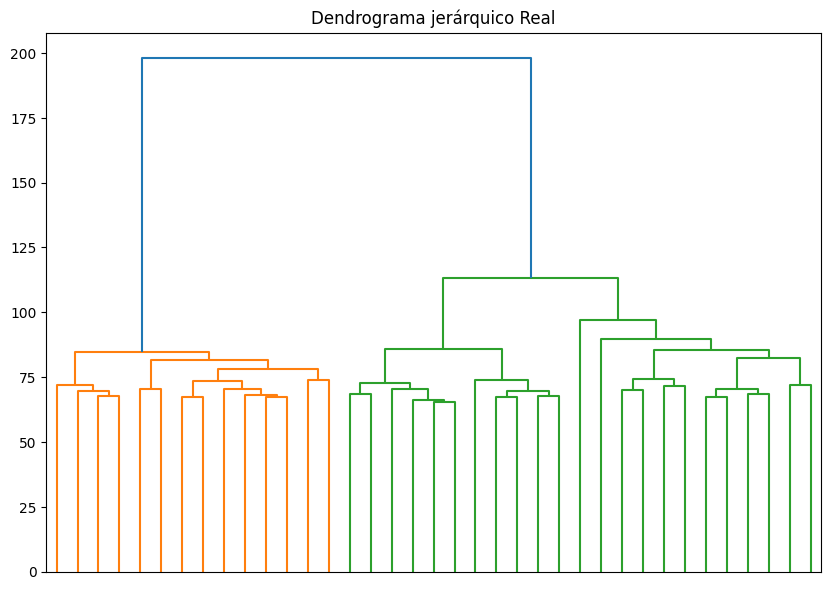

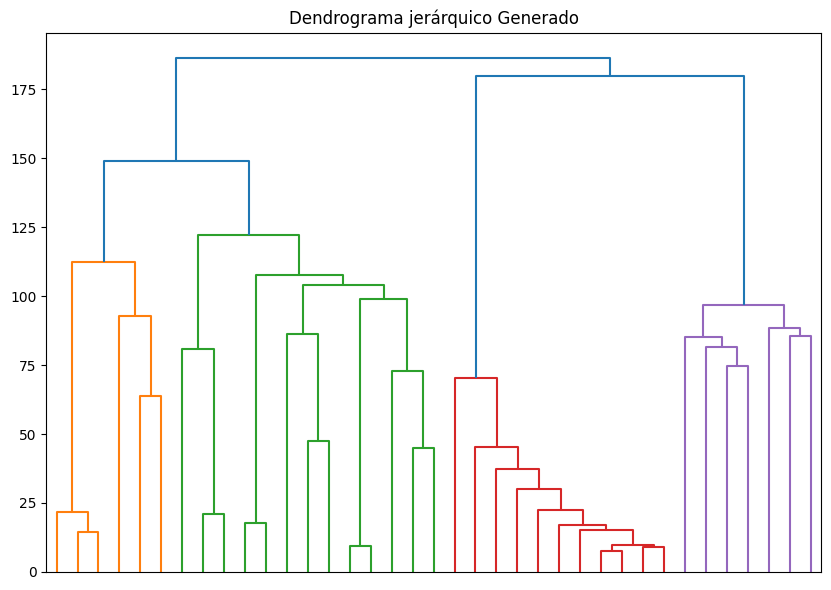

/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


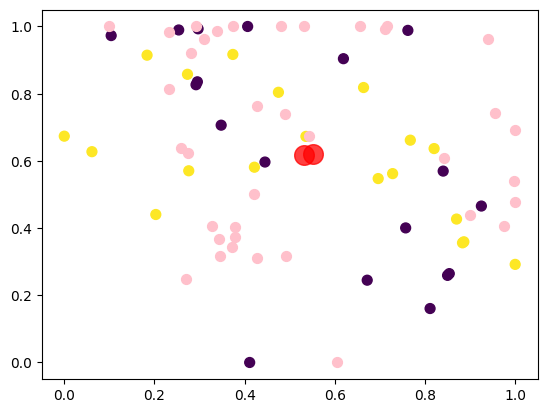

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

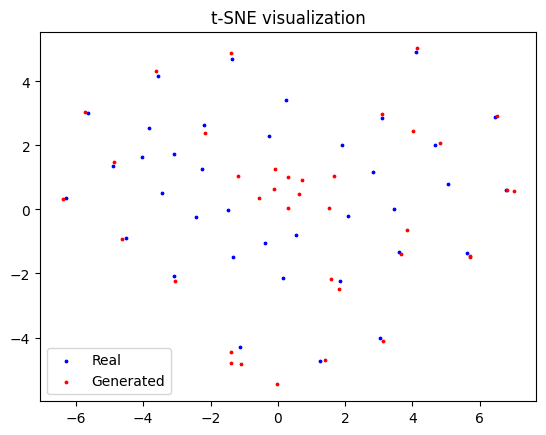

/home/fede/PyEnv/PB/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


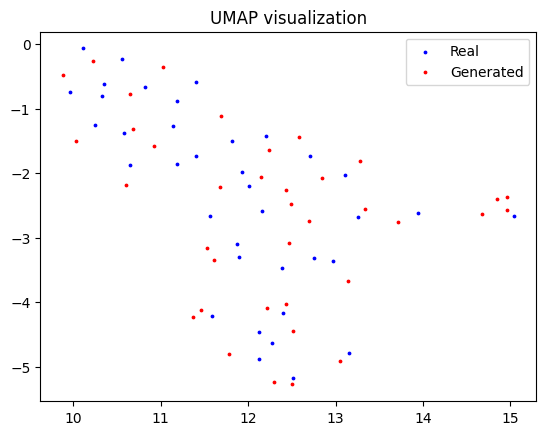

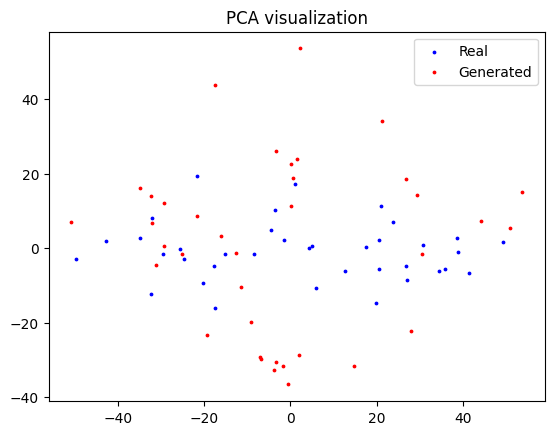

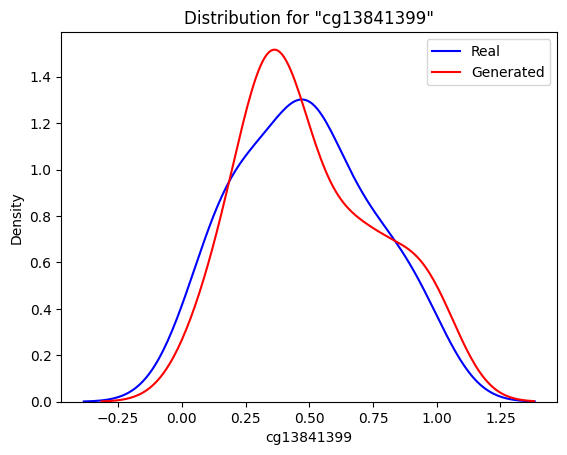

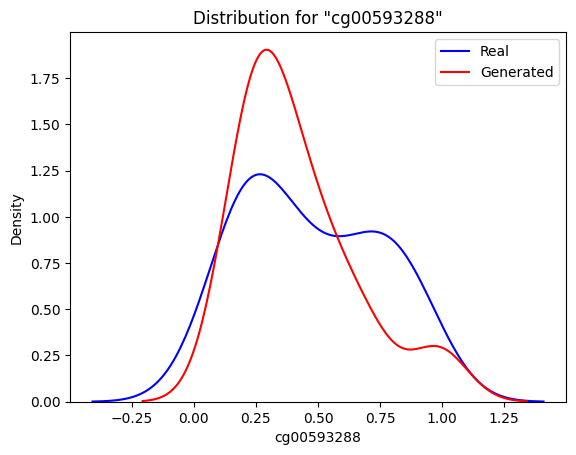

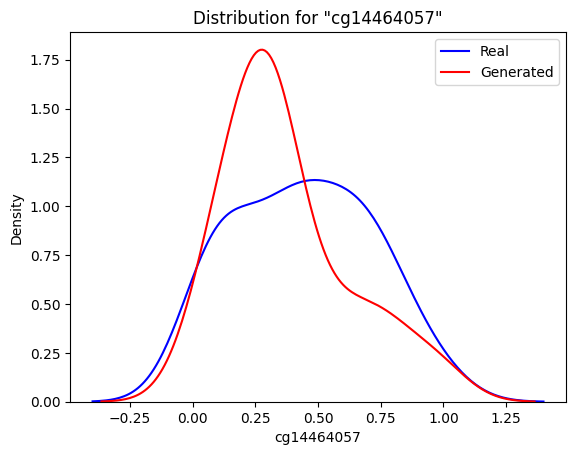

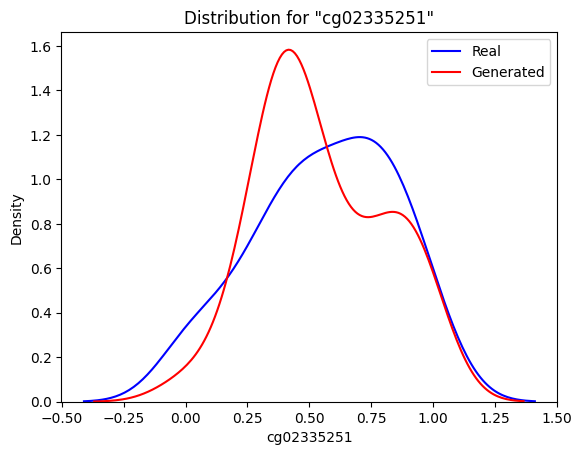

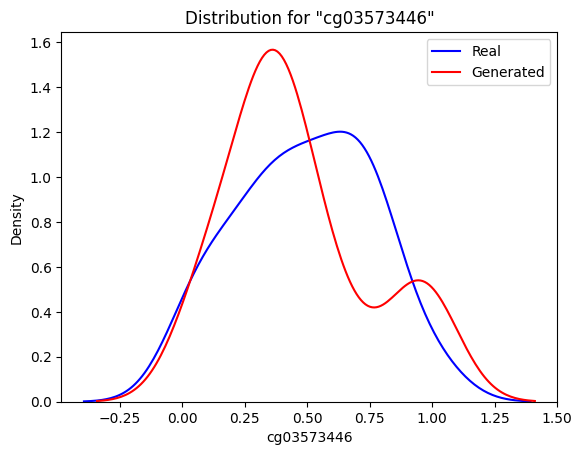

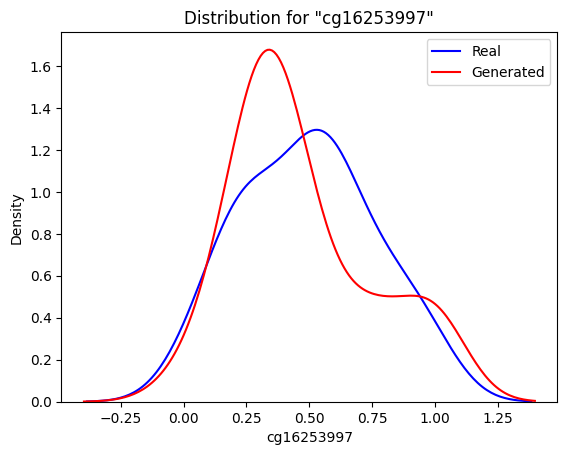

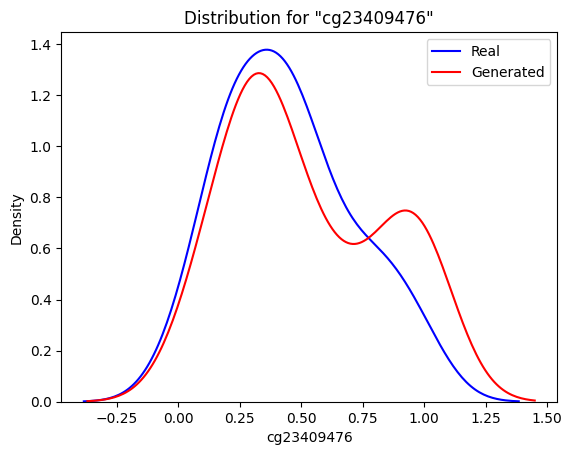

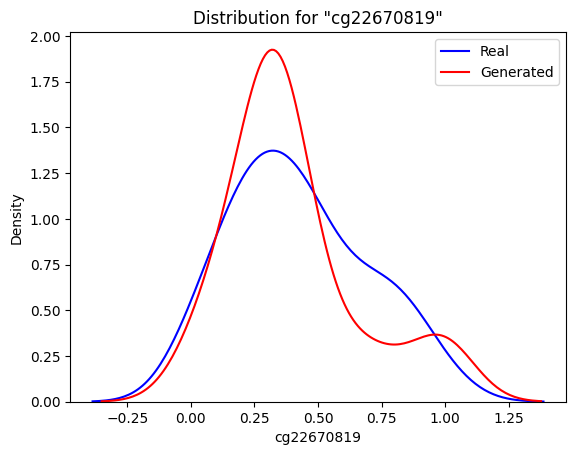

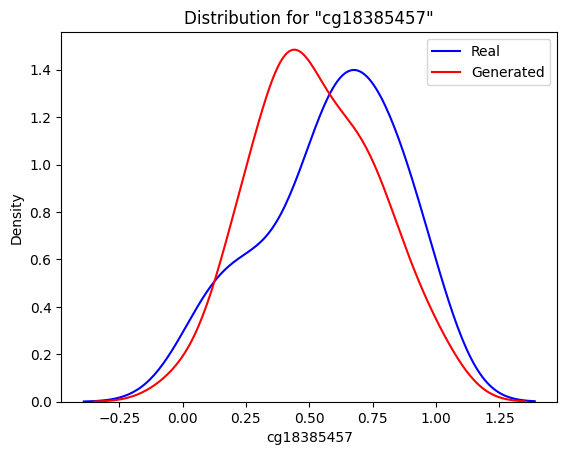

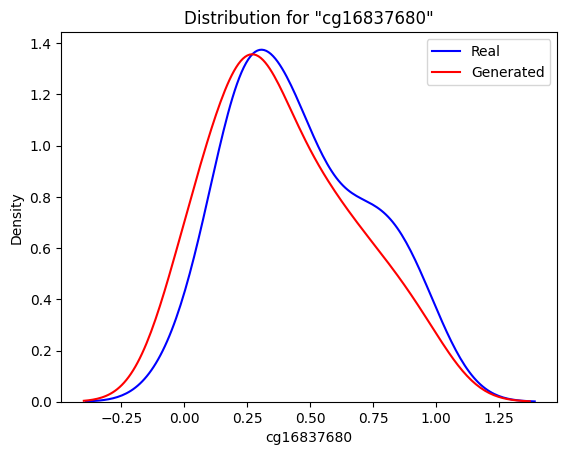

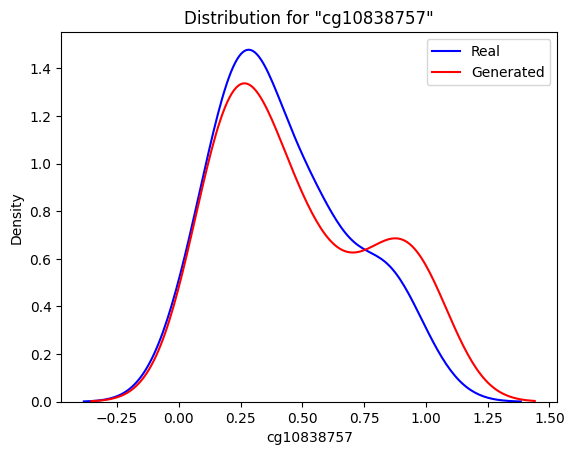

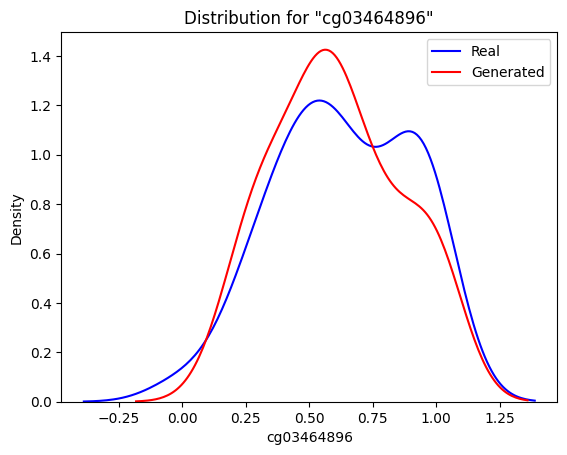

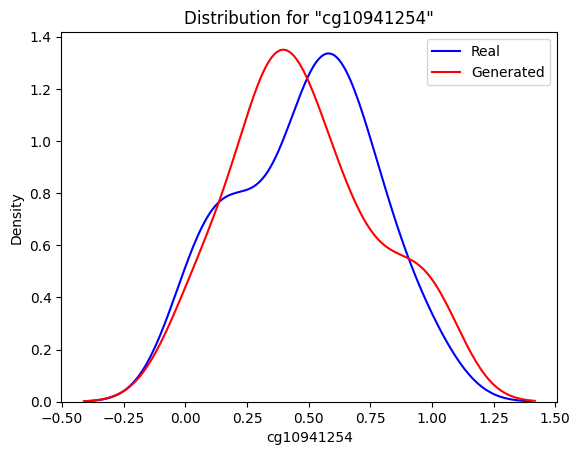

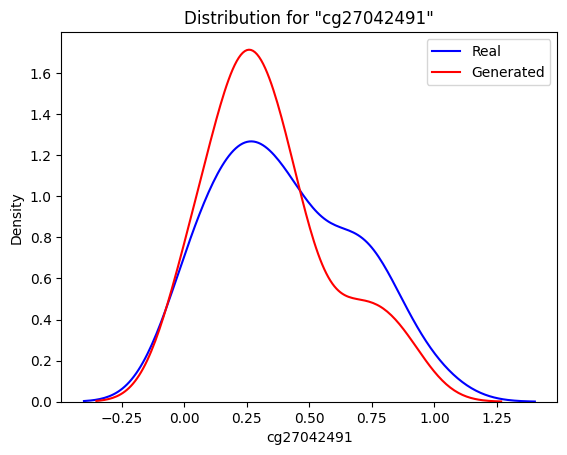

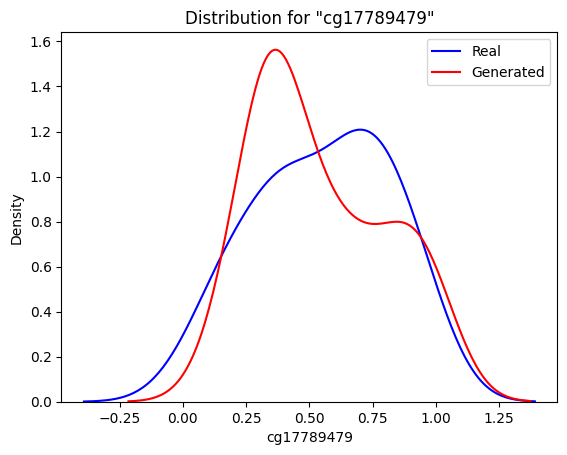

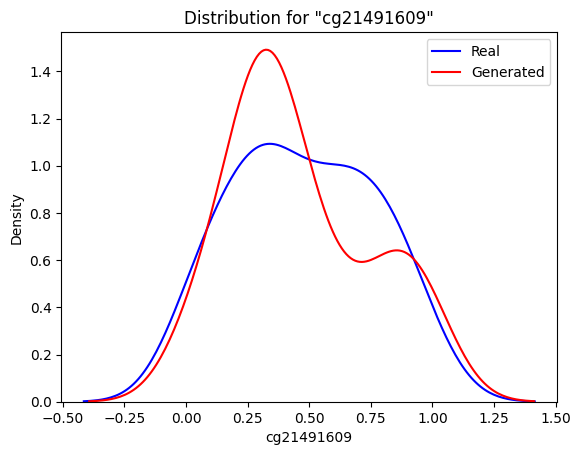

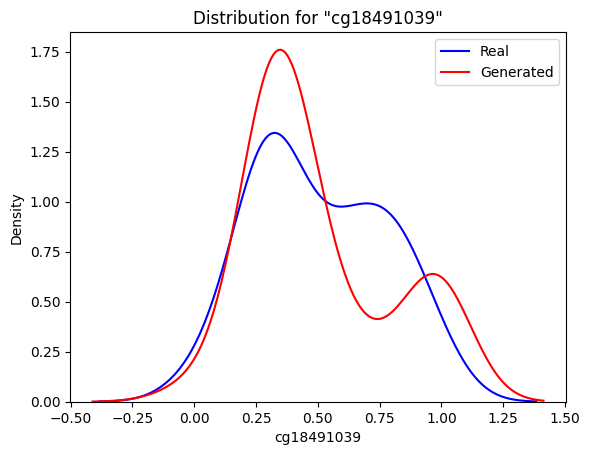

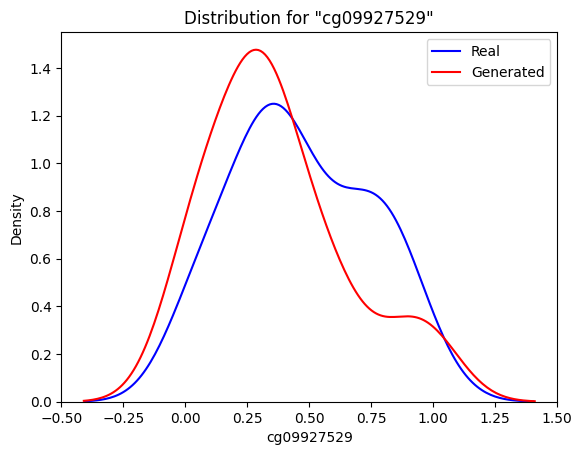

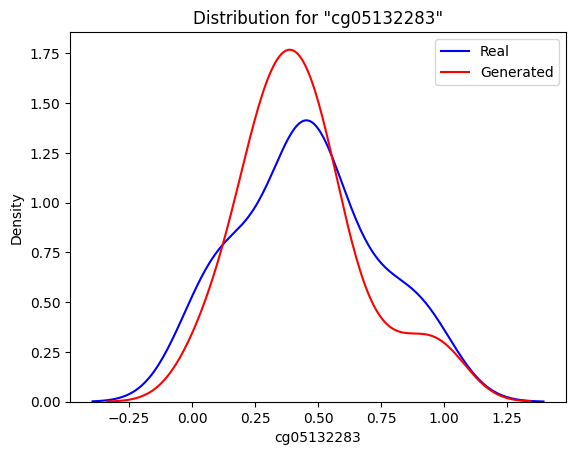

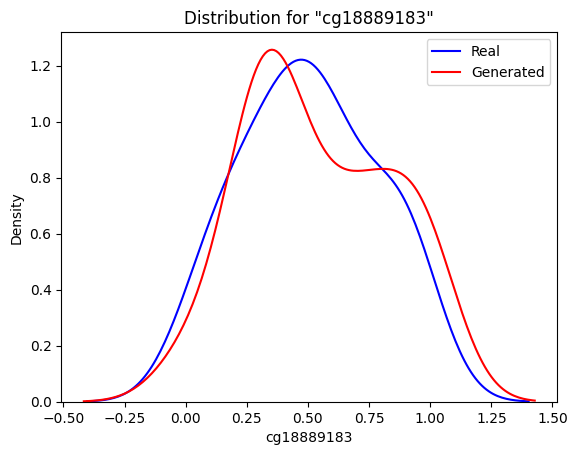

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import umap

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.setrecursionlimit(20000)




# Eliminar estas columnas del DataFrame
expr_data = expression_data

meth_data = methylation_data
assig_data=assign_data
# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)


# Generar datos de expresión sintética
gen2 = Generator(100, expr_data.shape[1]+meth_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load(f"{fnmodel}.pth"))
gen2.eval()
expressions_list = []
for i in range(nsamp):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X_gan = pd.DataFrame(expressions_list)

y = X_gan.iloc[:, -1].values.astype(int)  # Suponiendo que la asignación está en la primera columna

X = X_gan.iloc[:, :-1]

last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])


# Aplanar los datos para cálculos estadísticos
real_data_flattened = X_real.values.flatten()
generated_data_flattened = X_gan.values.flatten()

# Wasserstein Distance
w_distance = wasserstein_distance(real_data_flattened, generated_data_flattened)

# KS Test y Wassertein Distance
ks_statistic, ks_pvalue = ks_2samp(real_data_flattened, generated_data_flattened)

print(f"Wasserstein Distance: {w_distance}")
print(f"KS Statistic: {ks_statistic}, P-Value: {ks_pvalue}")


# Distancia Euclidiana
distancias_euclidianas = cdist(X_real, X_gan, metric='euclidean')
distancia_promedio_euclidiana = np.mean(distancias_euclidianas)
print("Distancia Euclidiana Promedio:", distancia_promedio_euclidiana)

# Calcula las matrices de correlación
#corr_real = X_real.corr()
#corr_gan = X_gan.corr()


# Dibuja las matrices de correlación
#plt.figure(figsize=(12, 6))

#plt.subplot(1, 2, 1)
#sns.heatmap(corr_real, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Correlation Matrix (Real Data)')

#plt.subplot(1, 2, 2)
#sns.heatmap(corr_gan, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Correlation Matrix (Generated Data)')

#plt.show()

# Calcula la matriz de diferencias
#corr_diff = corr_real - corr_gan

# Dibuja la matriz de diferencias
#plt.figure(figsize=(8, 6))
#sns.heatmap(corr_diff, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Difference in Correlation Matrices')
#plt.show()

# Etiquetas: 1 para real, 0 para generado
y_real = [1] * X_real.shape[0]
y_gan = [0] * X_gan.shape[0]

# Combina los datos y las etiquetas
y_combined = y_real + y_gan

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Inicializa y entrena el clasificador SVC
svc = SVC()
svc.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = svc.predict(X_test)
# Evalúa el rendimiento del clasificador
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
plt.title('Clasificación de datos reales y generados juntos')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(filename+"SVC1.jpg")
plt.show()


# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
unique_classes = np.unique(y_train)
if len(unique_classes) > 1:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
    plt.xlabel('Predicted')
    plt.title('Clasificación de datos generados')
    plt.ylabel('Truth')
    plt.savefig(filename+"SVC2.jpg")
    plt.show()
else:
    print("SVC: Solo una clase")

# Combinamos los datos de expresión génica y metilación
X2 = pd.concat([expr_data, meth_data], axis=1)
y2 = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.title('Clasificación de datos reales')
plt.ylabel('Truth')
plt.show()


# Clustering jerárquico
linked1 = linkage(X_real, method='ward')
linked2 = linkage(X_gan, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked1, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Real")
plt.savefig(filename+"DJR.jpg")
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(linked2, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Generado")
plt.savefig(filename+"DJG.jpg")
plt.show()


# K-Means
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_real)
labels = kmeans.predict(X_real)
centroids = kmeans.cluster_centers_
X_array = X_real.values
generated_data=X_gan.values
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=50, color='pink', label='Datos Generados')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75)
plt.savefig(filename+"KNN.jpg")
plt.show()

# Aplicar t-SNE
# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
plt.savefig(filename+"tsne.jpg")
plt.show()

# Configurando y entrenando UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_combined)

# Dibujando la visualización
plt.scatter(X_umap[labels==1, 0], X_umap[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_umap[labels==0, 0], X_umap[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('UMAP visualization')
plt.savefig(filename+"umap.jpg")
plt.show()

#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
plt.savefig(filename+"pca.jpg")
plt.show()

#KDE
column_names = X_real.columns.tolist()
random_columns = random.sample(column_names, 20)
for column_name in random_columns:
    sns.kdeplot(X_real[column_name], label='Real',color='blue')
    sns.kdeplot(X_gan[column_name], label='Generated',color='red')
    plt.legend()
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"{filename}kde-{column_name}.jpg")
    plt.show()